# Парсинг отзывов об Okko со стороннего агрегатора отзывов

# Содержание

**Часть 0: Описание задачи
<br>
<br>
Часть 1: Парсинг данных и их организация в табличный вид
<br>
<br>
Часть 2: Анализ полученных данных
<br>
<br>
Часть 3: Заключение**

# Часть 0: Описание задачи

Отдел CX-аналитики Okko заботится о своих пользователях и хочет знать, что им нравится в сервисе, а что - нет. 
<br>
Любители кино часто оставляют отзывы о том или ином стриминге на сторонних площадках. Полезно будет изучить эти данные, поверх той информации, которую Okko собирает внутри своей платформы.
<br>
<br>
Посмотрим на сайт отзывов https://www.otzyvru.com/okko
<br>
<br>
Здесь сверху мы можем видеть среднюю оценку, количество оценок, их соотношение.
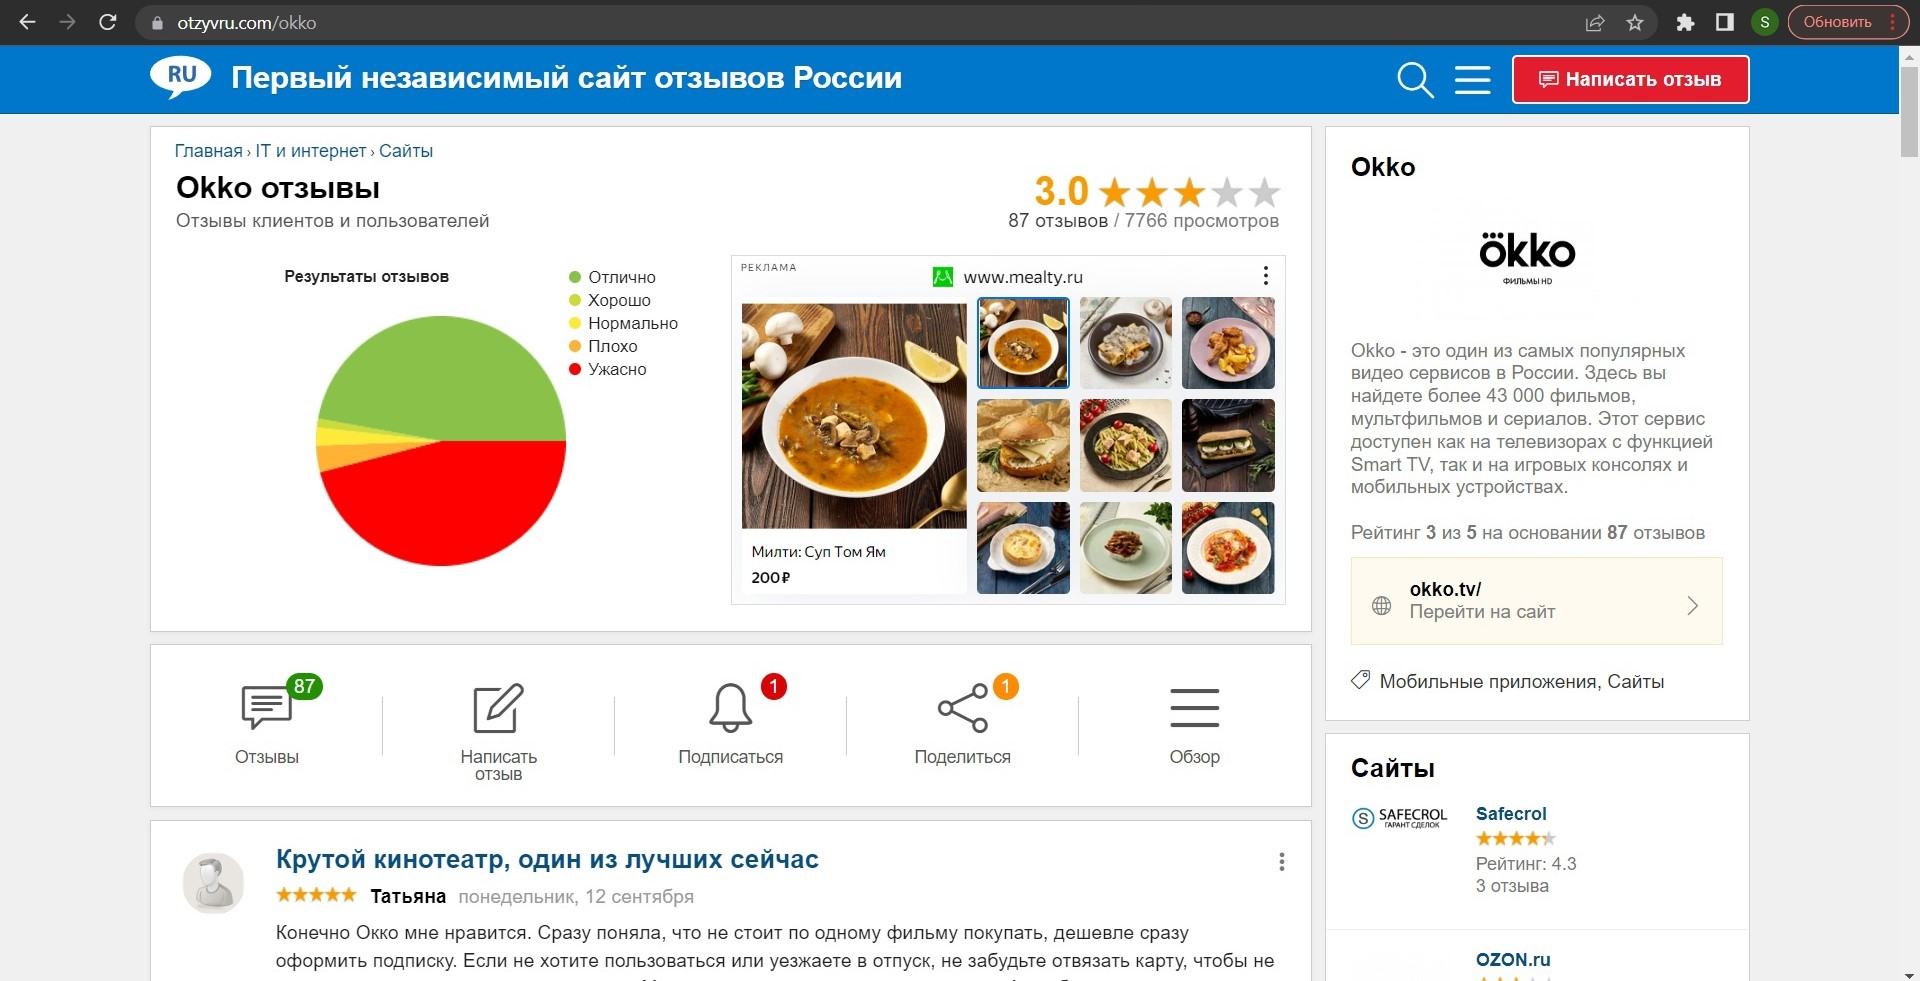

Внизу расположены отзывы. Следует учитывать 3 вещи:
<br>
1) Отзывы бывают короткие и укладываются в одну страницу. А бывает, что текст отзыва слишком длинный и для того, чтобы получить его полностью, приходится переходить на страничку самого отзыва
<br>
2) Сайт дает возможность указывать преимущества и недостатки сервиса. Но можно этого и не делать. Поэтому есть различия в форматах отзывов
<br>
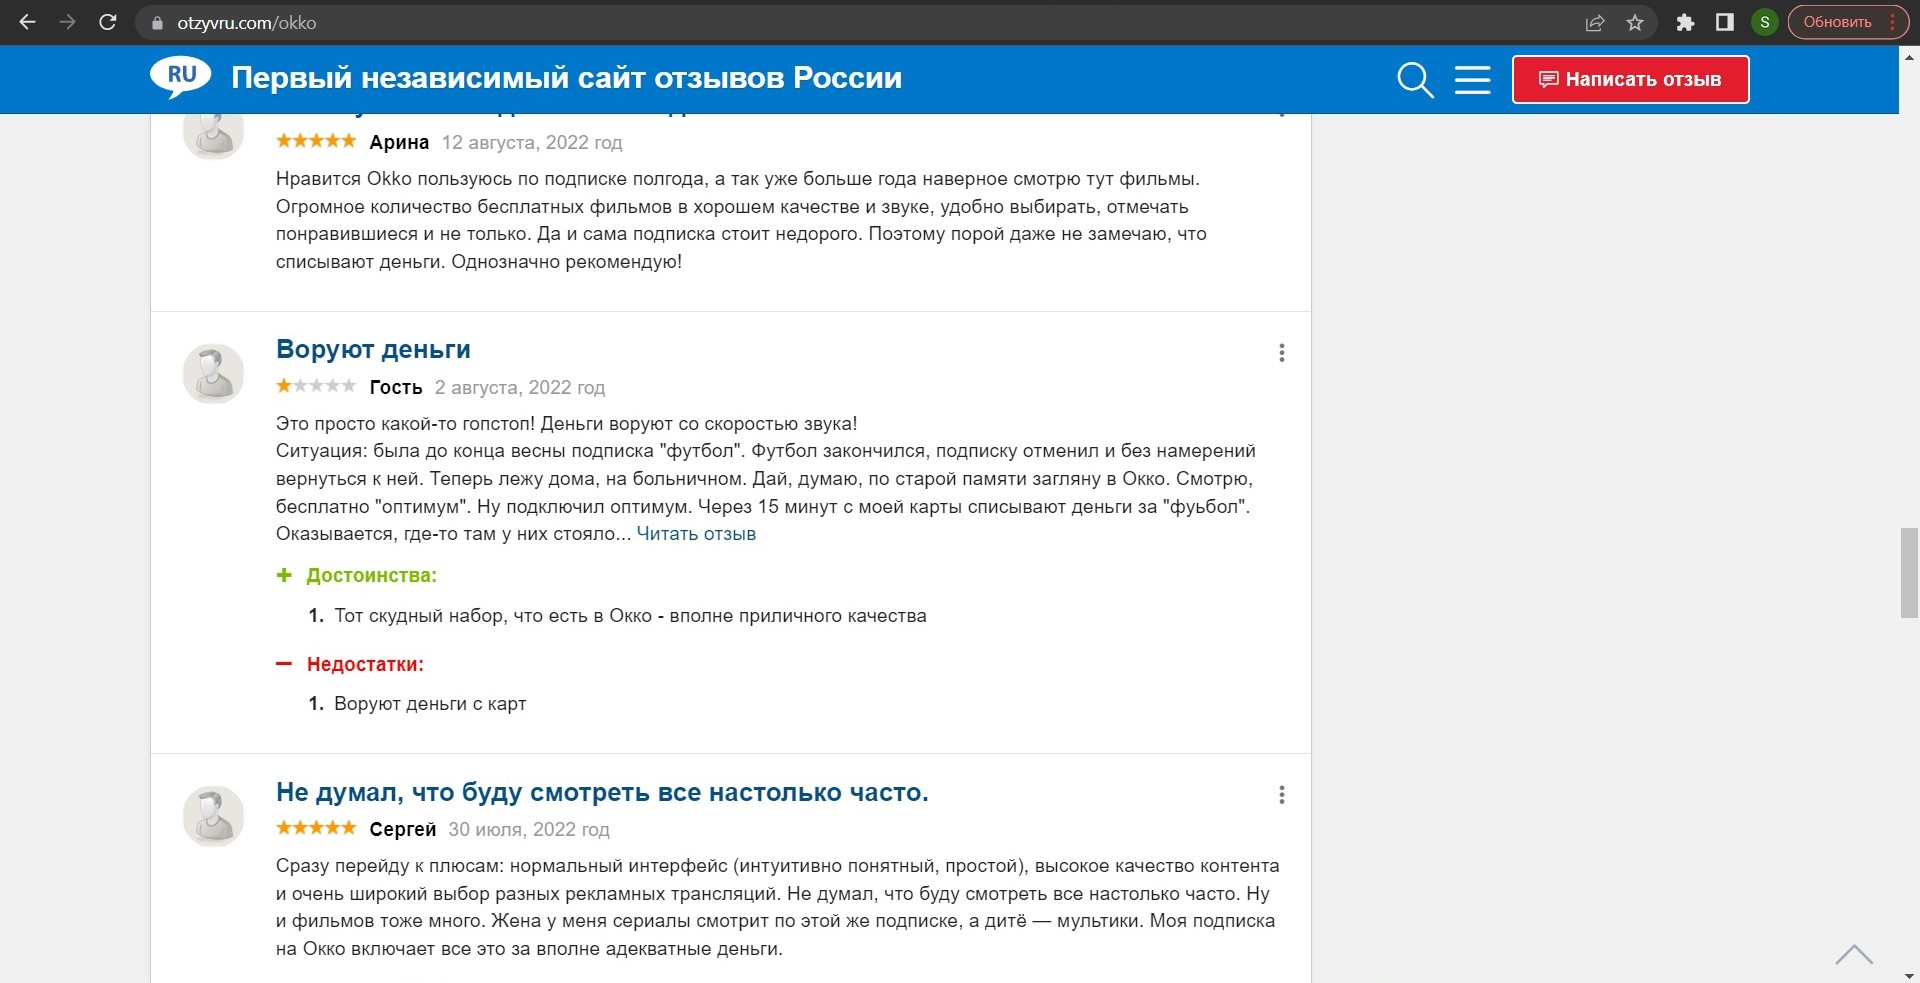

3) На одной странице - ограниченное количество отзывов. Внизу предлагается расширить список отзывов.
<br>
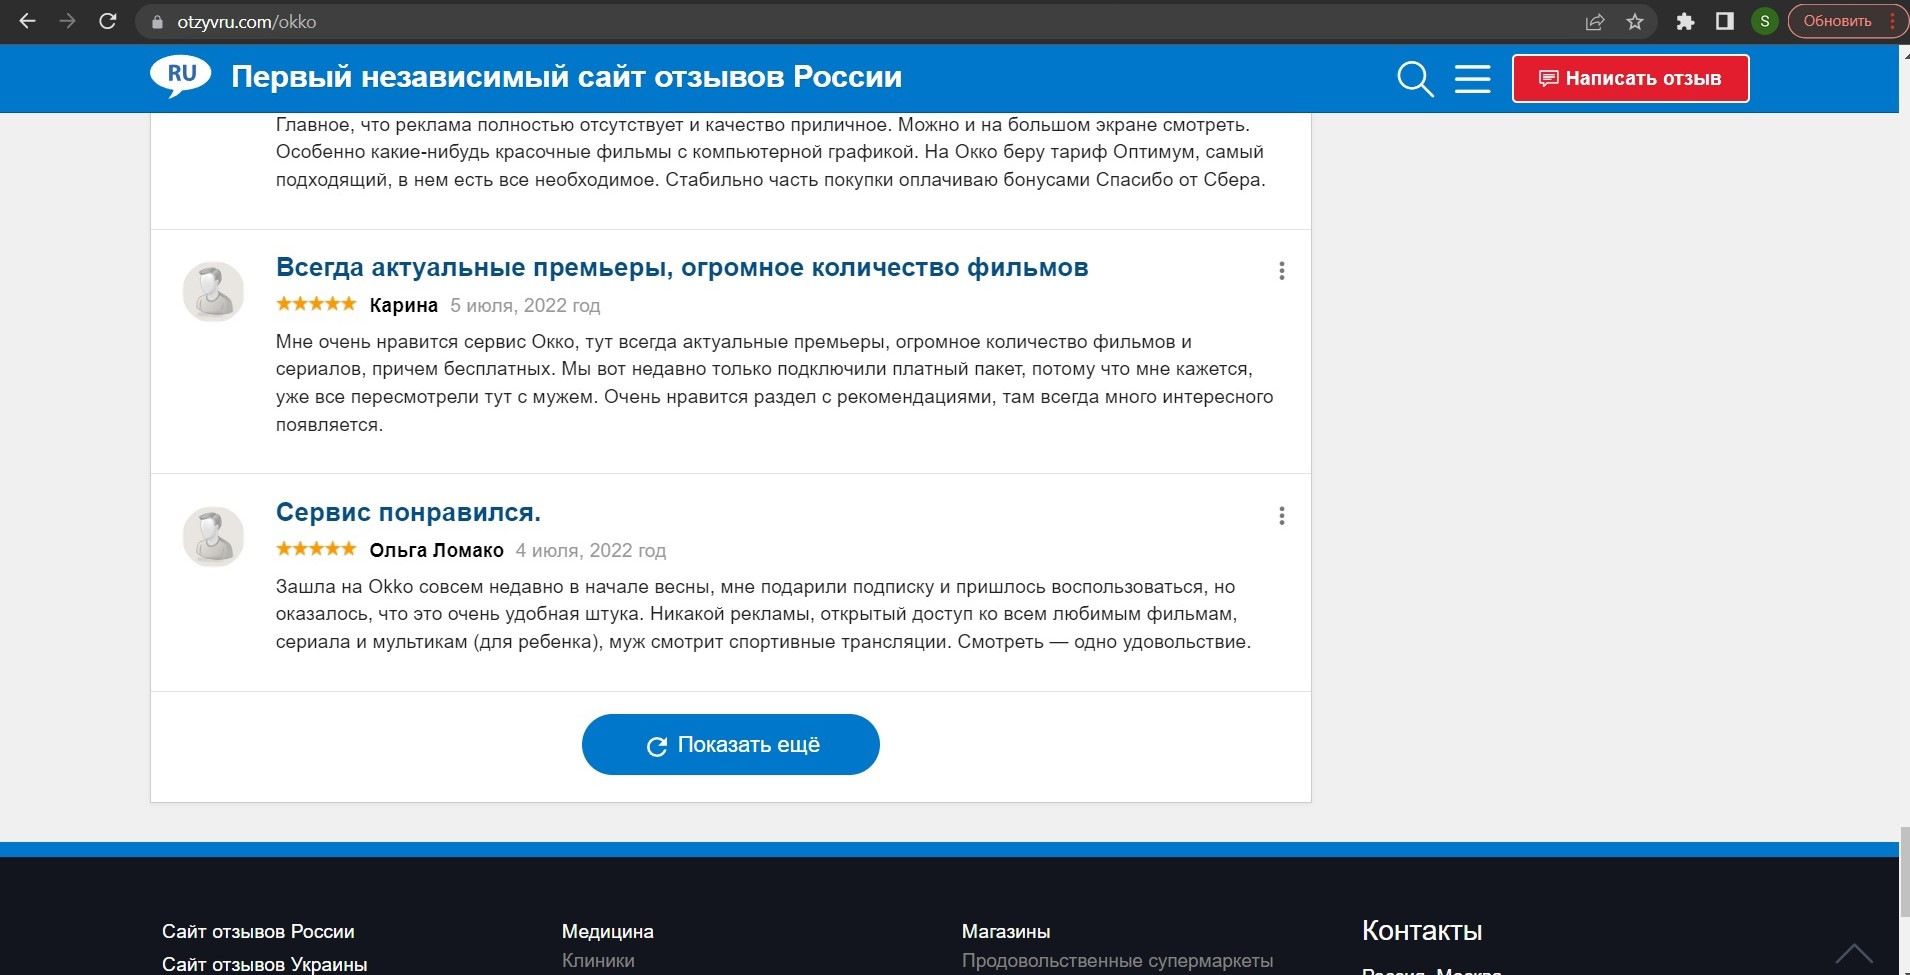
<br>
Все это необходимо учитывать, прописывая код, так как парсить можно только те данные, которые непосредственно отображаются на странице, ссылка на которую указана в начале
<br>
<br>
Соберем по каждому отзыву данные об имени написавшего, дате, оценке, достоинствах и недостатках (если есть) и сам текст отзыва

# Часть 1: Парсинг данных и их организация в табличный вид

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
i = 1
next_page = True
names_list = []
date_list = []
rating_list = []
adv_list = []
disadv_list = []
text_list = []

while next_page:
    
#   начинаем цикл с первой страницы со всеми отзывами
#   дальше счетчик i будет увеличиваться, пока не закончится опция "показать еще"
    url = 'https://www.otzyvru.com/okko?page={}'.format(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
#   теперь будем переходить отдельно на каждый отзыв, чтобы выгрузить максимально полную информацию
    separate_reviews = soup.find_all('h2')[:-1]
    for n, element in enumerate(separate_reviews, start=1):
        link = element.find('a').get('href')
        
        new_url = link
        new_response = requests.get(new_url)
        new_soup = BeautifulSoup(new_response.text, 'lxml')
        
#       добавляем в списки нужных нам параметров (имя, дата и т.д.) данные с каждого отзыва на каждой странице
        names_list.append(new_soup.find_all('div', class_='comment_header')[0].find('span', class_='reviewer').text)
        date_list.append(new_soup.find('script', {'type': 'application/ld+json'}).text.split('"')[11].split('T')[0])
        rating_list.append(new_soup.find_all('span', {'itemprop': 'reviewRating'})[0] \
                           .find('meta', {'itemprop': 'ratingValue'}).get('content'))
        text_list.append(new_soup.find_all('span', class_='comment description')[0].text)
        adv_list.append(new_soup.find_all('div', class_='advantages')[0].find('li').text 
                        if len(new_soup.find_all('div', class_='advantages')) > 0 
                        else '')
        disadv_list.append(new_soup.find_all('div', class_='disadvantages')[0].find('li').text 
                           if len(new_soup.find_all('div', class_='disadvantages')) > 0 
                           else '')
        
#   прописываем отдельный блок, который позволит прервать цикл, когда опции "показать еще" больше не будет 
    try:
        soup.find('div', class_='my_pagination').find('a').get('href')
    except:
        next_page = False
    i += 1  
    
# создаем датафрейм, добавляем в него собранные данные и приводим их к нужному типу  
otzyvru_df = pd.DataFrame({'name': names_list, 'date': date_list, 'rating': rating_list,
                           'advantages': adv_list, 'disadvantages': disadv_list, 'comment': text_list})
otzyvru_df['date'] = pd.to_datetime(otzyvru_df['date'])
otzyvru_df['rating'] = otzyvru_df['rating'].astype(int)

In [5]:
# настроим отображение таблицы, в котором будет виден весь отзыв целиком, какой бы длинный он ни был
pd.set_option("display.max_colwidth", None)

In [6]:
otzyvru_df.tail(5)

,name,date,rating,advantages,disadvantages,comment
82,Маргарита,2020-07-31,1,"Хорошее качество фильмов, больше плюсов нет !","Выбор новинок скуден и как правило все новинки платные, цена как в кинотеатре. Списывают деньги с карты каждый раз , за подписки которые сами и подключают .","Ужас , просто обдираловка. Никогда не писала отзывы, но когда в очередной раз с карты списывают 500 рублей , хочется что бы они на эти деньги купили свою последнюю дозу. Оформляешься подписку, выключаешь автопродление и потом чудесным образом какая нибудь подписка сама подключается!!!!!! Вот что трудно уведомление какое нибудь сделать , о подписки или ее окончании????Надеюсь что вы там все будете жить на одну пенсию по старости и у вас будут списывать с карты последние деньги , всякие мошен-ки вроде Вас!"
83,Андрей,2020-04-24,1,Нет,Нечистые на руку.,"Предлагают посмотреть фильм за 1 рубль, вы оплачиваете через карту, и через несколько дней списали с карты 799 руб."
84,Евгения,2020-04-06,1,,,"Качество сервиса оставляет желать лучшего : интересных фильмов не так много, при этом проблемы с использованием онлайн - кинотеатра могут возникнуть : сервис нагло ворует деньги без уведомлений за счет того, что подписки продлеваются автоматически. Чтобы избежать проблем, не следует привязывать карту к этому онлайн кинотеатру. Если же вы все-таки привязали карту, ее нужно отвязать с сайта и с телевизора, в противном случае, деньги будут списываться самым неожиданным образом. Не рекомендую этот сервис."
85,Евгений Буянов,2020-03-06,1,,,"Взял подписку на месяц, заказывал через телефон, оплачивал с карты - нигде не ставил галочку о помесячном продлении. Оказывается данная функция и списание средств с карты стоит по умолчанию. Да к тому же и контент в науке и образовании очень небольшой."
86,Игорь,2020-02-12,5,,,"Очень давно пользуюсь этим сервисом и остаюсь всем доволен.Главное что мне нравится в этом сервисе, это наличии огромного количества русского контента. Здесь я могу посмотреть абсолютно любой русский фильм, чего не скажешь об остальных сервисах, которые предлагают зачастую западный контент. Также не мало важным критерием для меня была цена. Благо с этим здесь тоже все хорошо. Я пользуюсь стандартной подпиской, за которую я плачу 500 рублей и это мне дает доступ к огромному количеству фильмов и сериалов! Ну и надо упомянуть простоту интерфейса, с которой в свои 50 лет я справился на ура! Так что если вы думаете на какой сервис перейти, то смело выбирайте Okko!"


In [4]:
otzyvru_df.dtypes

name                     object
date             datetime64[ns]
rating                    int32
advantages               object
disadvantages            object
comment                  object
dtype: object

Выгрузили все 87 отзывов, все отображается корректно, все типы данных правильные

# Часть 2: Анализ полученных данных

In [7]:
otzyvru_df = otzyvru_df.sort_values('date').set_index('date')

In [9]:
otzyvru_df.groupby(pd.Grouper(freq='M')).agg({'rating': 'count'})

,rating
date,
2020-02-29,1
2020-03-31,1
2020-04-30,2
2020-05-31,0
2020-06-30,0
2020-07-31,1
2020-08-31,0
2020-09-30,1
2020-10-31,0


Сгруппировав данные по месяцам, мы увидели, что, во-первых, информация есть с февраля 2020 по сентябрь 2022, а во-вторых, что большую часть времени в месяц оставляли всего 0-3 отзыва. И только с апреля 2022 отзывов стало 5 и более. Усреднение такой оценки даст хоть какую-то показательную картину, поэтому для дальнейшего анализа посмотрим на отзывы за последние почти полгода

In [33]:
otzyvru_df.query("date > '2022-04-01'").rating.mean()

4.36734693877551

Средняя оценка за полгода - 4.4. Вполне неплохо

In [12]:
otzyvru_df.query("date > '2022-04-01'").groupby(pd.Grouper(freq='M')).agg({'rating': 'mean'}).round(2)

,rating
date,
2022-04-30,3.40
2022-05-31,3.40
2022-06-30,3.78
2022-07-31,5.00
2022-08-31,4.56
2022-09-30,5.00


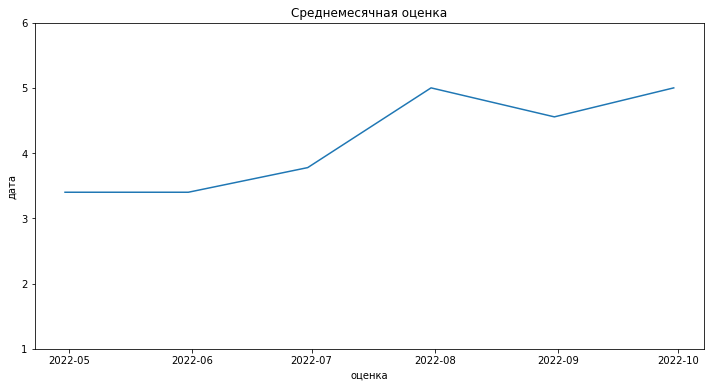

In [31]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=otzyvru_df.query("date > '2022-04-01'").groupby(pd.Grouper(freq='M')).agg({'rating': 'mean'}),
             x='date',
             y='rating') 
ax = ax.set(ylim=(1,6), title='Среднемесячная оценка', xlabel='оценка', ylabel='дата')

Видим, что за последние полгода среднемесячная оценка в целом растет. Так, все оценки за сентябрь - исключительно 5.
<br>
<br>
Посмотрим, что пишут люди в отзывах

In [38]:
otzyvru_df.query("date > '2022-04-01'").advantages.unique()

array(['', 'Сделали хорошо',
       'Тот скудный набор, что есть в Окко - вполне приличного качества'],
      dtype=object)

In [39]:
otzyvru_df.query("date > '2022-04-01'").disadvantages.unique()

array(['', 'Нет', 'Воруют деньги с карт'], dtype=object)

In [34]:
otzyvru_df.query("date > '2022-04-01'").comment

date
2022-04-03                                                                                                                                                                                                                                                                                                                                                                                                                                                         Всем привет! 2 недели по подписке пробная за 1р., использую приложение окко. Раз в пять минут зависает от 5 до 20секунд, бывает и вообще помогает только перезагрущка. Хорошо, что не оформил подписку стандартную! В общем трэш!!! 
2022-04-05                                                                                                                                                                                                                                                                                                                 

Проблемы, которые выдаляют пользователи: зависает воспроизведение, наличие платного контента даже с подпиской, непрозрачность обращения в поддержку, снятие средств после конца пробной подписки, списание денег после отмены автопродления
<br>
<br>
При этом хвалят: качество видео, тарифы, обилие спортивных программ, большой каталог, возможность оплатить бонусами Спасибо, рекомендации, комментаторы спортивных программ
<br>
<br>
Комментарий на полях: несколько человек, которые взяли пробную подписку за 1 рубль, продлили ее и довольны сервисом

# Часть 3: Заключение

В целом отзывов об Okko на otzyvru не так много (87 штук за 2,5 года). Но последние полгода их стало больше. 
<br>
<br>
За последние полгода средняя оценка составила 4.4, а среднемесячная оценка выросла с 3.4 до 5.0.
<br>
<br>
В тексте отзыва среди недостатков чаще упоминают снятие средств при автопродлении (и даже при его отмене), зависание воспроизведения, наличие платного контента в подписке. Среди достоинств - качество видео, качественный спорт-контент, ассортимент и рекомендации
<br>
<br>
На следующих этапах будет полезно спарсить данные с других площадок для отзывов (в том числе тех, которые защищаются от парсинга), а также собрать данные по конкурентам (Кинопоиск, ivi и т.д.) и сравнить